In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from scipy.sparse.linalg import norm

In [2]:
import sys
sys.path.insert(0, "../scripts")

from SZFW_lasso import *
from DZFW_lasso import *
from IZFW_lasso import *

## Load data

In [3]:
# load data
X, y = datasets.load_svmlight_file("../Data/covtype.libsvm.binary.scale.bz2")

In [4]:
# space dimension
d = X.shape[1]
n = y.shape[0]
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")

Space Dimensions
d: 54
n: 581012


In [5]:
# define the objective function
F = lambda w: 0.5/n * np.sum(np.power(y - X @ w, 2))

In [6]:
# initialize prarameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

indeces = np.random.randint(low = 0, high = d-1, size = 20)
w0[indeces] = int(0)
w0 = np.zeros(d)
print(f"w0: {w0}")

w0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


## Deterministic Gradient Free Frank Wolfe

In [7]:
%%time

# Lipschitz constant 
L = 3

fpred, f, w, mean, t, loss, f_values = detZFW(F, L, d, w0, T=5)

Loss evaluation at time 1:	0.7013836

Loss evaluation at time 2:	0.1212442

Loss evaluation at time 3:	0.0424383

Loss evaluation at time 4:	0.0199207

Loss evaluation at time 5:	0.0109946

Loss evaluation at time 6:	0.0067281

Loss evaluation at time 7:	0.0044241

Loss evaluation at time 8:	0.0030676

Loss evaluation at time 9:	0.0022159

Loss evaluation at time 10:	0.0016536

CPU times: user 10.1 s, sys: 325 ms, total: 10.4 s
Wall time: 10.5 s


In [8]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 1.2313988351359353

F(w_pred) = 0.3189816575550478

F(w) = 0.317328069772405

w = [0.         0.         0.         0.         0.         0.
 0.         0.98484848 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]

average w = [0.         0.         0.         0.         0.         0.
 0.         0.91666667 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.      

In [9]:
lossd = np.load("../Data/results/loss_dZFW_lasso.npy") # data from colab (NOT NORMALIZED)
f_d = np.load("../Data/results/function_dZFW_lasso.npy")
f_d = f_d/n
f_star = np.min(f_d)

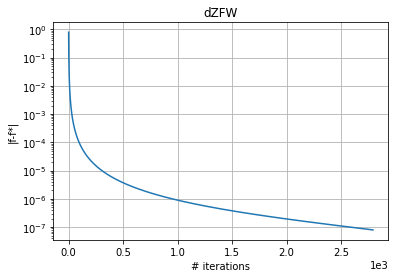

In [10]:
F_evald = np.abs(f_d - f_star)
plt.plot(F_evald[:-2000])
plt.yscale("log")
plt.title("dZFW")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

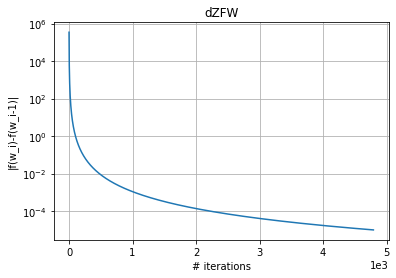

In [11]:
plt.plot(lossd)
plt.yscale("log")
plt.title("dZFW")
plt.xlabel("# iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.grid()

## Stochastic Gradient Free Frank Wolfe

In [12]:
%%time
fpred, f, w, mean, t, loss, f_values = stochasticZFW(F, d, w0, method = "IRDSA1", r=1, T=10, eps=1e-10)

Loss evaluation at time 1:	0.0275749

Loss evaluation at time 2:	0.0056888

Loss evaluation at time 3:	0.2195518

Loss evaluation at time 4:	0.0789956

Loss evaluation at time 5:	0.0358417

Loss evaluation at time 6:	0.1041304

Loss evaluation at time 7:	0.0282238

Loss evaluation at time 8:	0.0458985

Loss evaluation at time 9:	0.0664736

Loss evaluation at time 10:	0.0526058

CPU times: user 1.48 s, sys: 11.6 ms, total: 1.5 s
Wall time: 1.5 s


In [13]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 1.2313988351359353

F(w_pred) = 0.722194251100365

F(w) = 0.6695884777393749

w = [ 0.16339869  0.07843137  0.          0.          0.          0.
  0.21568627  0.1503268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.09803922
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.05228758  0.          0.          0.         -0.05882353  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]

average w = [ 0.12222222  0.06666667  0.          0.          0.          0.
  0.03333333  0.14444444  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.03333333
  0.          0.  

In [14]:
loss_stochm6 = np.load("../Data/results/loss_SZFWm6_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm6 = np.load("../Data/results/function_SZFWm6_lasso.npy")
f_stochm6 = f_stochm6/n

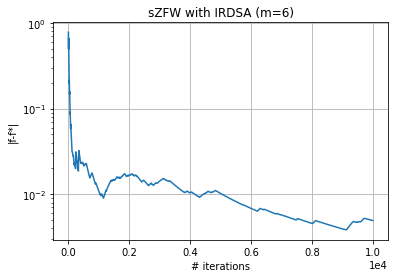

In [15]:
F_evalsm6 = np.abs(f_stochm6 - f_star)
plt.plot(F_evalsm6)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6)")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

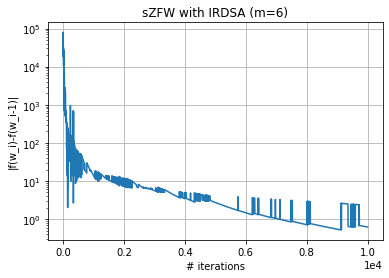

In [16]:
plt.plot(loss_stochm6)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6)")
plt.xlabel("# iterations")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

In [17]:
loss_stochm1 = np.load("../Data/results/loss_SZFWm1_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm1 = np.load("../Data/results/function_SZFWm1_lasso.npy")
f_stochm1 = f_stochm1/n

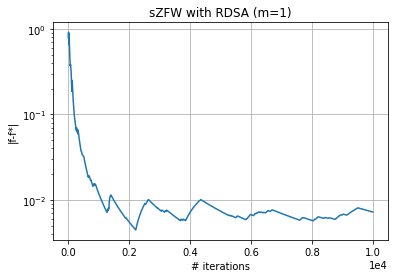

In [18]:
F_evalsm1 = np.abs(f_stochm1 - f_star)
plt.plot(F_evalsm1)
plt.yscale("log")
plt.title("sZFW with RDSA (m=1)")
plt.xlabel("# iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f-f*|")
plt.grid()

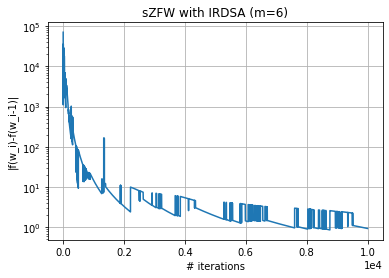

In [19]:
plt.plot(loss_stochm1)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6)")
plt.xlabel("# iterations")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

## Zeroth order stochastic accelerated gradient method with Inexact updates

In [20]:
%%time 

# setting parameters
L = 0.1
D = 10000 # we will start from m = 6, up to T * (T+1) / D * (d+3) = 28785 (for T=100)
B = 1

fpred, f, w, mean, t, loss, f_values, inner = IZFW(F, d, w0, L, B, r = 1, T = 2, eps = 1e-8)

Loss evaluation at time 1:	0.6730002

Loss evaluation at time 2:	0.1190347

CPU times: user 4.31 s, sys: 23.1 ms, total: 4.33 s
Wall time: 4.36 s


In [21]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 0.5583986179453985

F(w) = 0.4393639485847859

w = [0.         0.         0.         0.         0.         0.
 0.83333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]

average w = [0.   0.   0.   0.   0.   0.   0.75 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]

T = 2


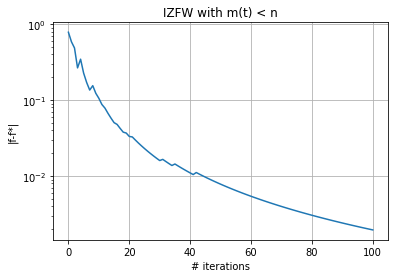

In [22]:
f_inex = np.load('../Data/results/function_IZFW_lasso.npy') # data from cluster
loss_inex = np.load('../Data/results/loss_IZFW_lasso.npy')
F_eval_inex = np.abs(f_inex/n - f_star)
plt.plot(F_eval_inex)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) < n")
plt.xlabel("# iterations")
plt.grid()

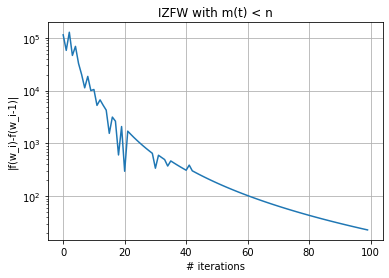

In [23]:
plt.plot(loss_inex)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) < n")
plt.xlabel("# iterations")
plt.grid()

## Result Comparison


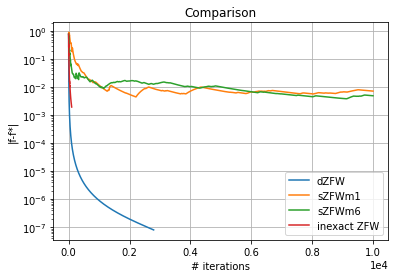

In [24]:
plt.plot(F_evald[:-2000])
plt.plot(F_evalsm1)
plt.plot(F_evalsm6)
plt.plot(F_eval_inex)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", "inexact ZFW"))
plt.grid()

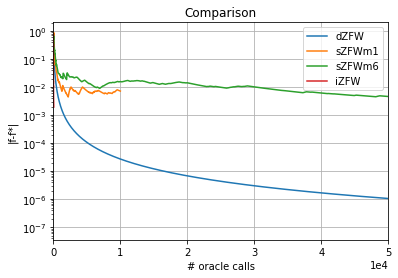

In [25]:
m = lambda t: t * (t+1) / D * (d+3)

plt.plot(range(1, len(F_evald)*d, d)[:-2000], F_evald[:-2000])
plt.plot(range(0, len(F_evalsm1)*1, 1), F_evalsm1)
plt.plot(range(0, len(F_evalsm6)*6, 6), F_evalsm6)
plt.plot([m(t) for t in range(101)], F_eval_inex)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", "iZFW"))
plt.yscale("log")
plt.title("Comparison")
plt.xlabel("# oracle calls")
plt.ylabel("|f-f*|")
plt.xlim((0,50000))
plt.grid()

# Test on artificial dataset


In [26]:
def CreateDataSet(n, d, s):
    """
    n rows, d features, s sparsity level
    """
    np.random.seed(1007)
    s = np.int(d * s)
    X = np.random.randn(n,d) 
    pn = int(s/2)
    w_s = np.concatenate((np.ones(pn), -np.ones(pn), np.zeros(d-2*pn)))
    w_s = w_s/np.sum(np.abs(w_s))
    epsilon = 0.01*np.random.rand(n) # noise
    y = X @ w_s + epsilon
    return X, y, w_s, epsilon

In [27]:
X, y, w_star, noise = CreateDataSet(n = 100, d = 1000, s = 0.05)

In [28]:
np.sum(np.abs(w_star))

1.0

In [29]:
# space dimension
d = X.shape[1]
n = y.shape[0]
f_star = F(w_star)
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")
print(f"f* = {f_star:.8f}")

Space Dimensions
d: 1000
n: 100
f* = 0.00001625


In [30]:
# initialize prarameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

indeces = np.random.randint(low = 0, high = d-1, size = int(d/2))
w0[indeces] = int(0)
print(f"w0: {w0[:10]}, {np.count_nonzero(w0)} elements different from zero")

w0: [0.00000000e+00 6.94725184e-05 5.32349094e-07 6.23650766e-05
 0.00000000e+00 2.30543109e-05 0.00000000e+00 4.58801767e-05
 6.46670184e-05 0.00000000e+00], 595 elements different from zero


## Deterministic Gradient Free Frank Wolfe

In [31]:
L = 2/X.shape[0] * np.linalg.norm(X.T @ X)

In [32]:
%%time

# Lipschitz constant 

fpred, f, w, mean, t, loss, f_valuesd = detZFW(F, L, d, w0, T=1000, eps = 1e-8)

Loss evaluation at time 1:	0.2869688

Loss evaluation at time 2:	0.2624069

Loss evaluation at time 3:	0.0283229

Loss evaluation at time 4:	0.0363124

Loss evaluation at time 5:	0.0025483

Loss evaluation at time 6:	0.0077457

Loss evaluation at time 7:	0.0023958

Loss evaluation at time 8:	0.0006643

Loss evaluation at time 9:	0.0035124

Loss evaluation at time 10:	0.0015967

Loss evaluation at time 11:	0.0036494

Loss evaluation at time 12:	0.0023726

Loss evaluation at time 13:	0.0035014

Loss evaluation at time 14:	0.0010940

Loss evaluation at time 15:	0.0018221

Loss evaluation at time 16:	0.0000485

Loss evaluation at time 17:	0.0014287

Loss evaluation at time 18:	0.0023645

Loss evaluation at time 19:	0.0007307

Loss evaluation at time 20:	0.0011386

Loss evaluation at time 21:	0.0002368

Loss evaluation at time 22:	0.0005389

Loss evaluation at time 23:	0.0001284

Loss evaluation at time 24:	0.0002807

Loss evaluation at time 25:	0.0003878

Loss evaluation at time 26:	0.0004

In [33]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 0.009659341411376754

F(w_pred) = 0.0001572218539217139

F(w) = 0.00015722510307105125

w = [ 0.00000000e+00  2.19669002e-09  1.68326407e-11  1.97195588e-09
  0.00000000e+00  6.60848742e-03  0.00000000e+00  1.45071070e-09
  3.69948981e-03  0.00000000e+00  0.00000000e+00  4.74515930e-10
  7.92202773e-10  1.42048216e-09  2.24498830e-03  2.63663869e-09
  2.16029669e-09  0.00000000e+00  0.00000000e+00  9.68511210e-10
  0.00000000e+00  7.27249923e-03  0.00000000e+00  2.29969919e-10
  2.68046521e-09  2.71493511e-09  1.97556516e-09  4.74539905e-10
 -2.08688928e-03 -5.47018276e-03  0.00000000e+00 -2.44419149e-02
  0.00000000e+00  1.36442998e-09 -4.64807437e-03  0.00000000e+00
 -2.40624782e-02  2.54195325e-10  1.46595254e-09 -4.90103080e-03
  0.00000000e+00  2.70281978e-09 -3.41491178e-03  6.71313771e-10
 -6.98792133e-03  0.00000000e+00 -1.07190286e-02  2.33145447e-09
  1.47518269e-09  1.43269332e-10  0.00000000e+00 -7.11439890e-03
  0.00000000e+00  2.30688825e-09  2.00583715e-

In [34]:
loss_ad = np.load("../Data/results/loss_dZFW_lasso_AD.npy")
f_valuesd = np.load("../Data/results/function_dZFW_lasso_AD.npy")

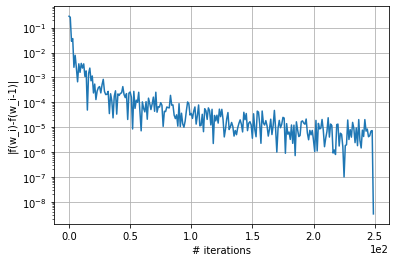

In [35]:
plt.plot(loss_ad)
plt.yscale("log")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.xlabel("# iterations")
plt.grid()

## Stochastic Gradient Free Frank Wolfe

In [36]:
%%time
fpred, f, w, mean, t, loss, f_valuess = stochasticZFW(F, d, w0, method = "IRDSA2", r=1, T=1000, eps=1e-8)

Loss evaluation at time 1:	0.0235488

Loss evaluation at time 2:	0.0041638

Loss evaluation at time 3:	0.0074961

Loss evaluation at time 4:	0.0013408

Loss evaluation at time 5:	0.0002935

Loss evaluation at time 6:	0.0048255

Loss evaluation at time 7:	0.0039489

Loss evaluation at time 8:	0.0150047

Loss evaluation at time 9:	0.0124152

Loss evaluation at time 10:	0.0033470

Loss evaluation at time 11:	0.0008387

Loss evaluation at time 12:	0.0035966

Loss evaluation at time 13:	0.0020358

Loss evaluation at time 14:	0.0036083

Loss evaluation at time 15:	0.0030197

Loss evaluation at time 16:	0.0032500

Loss evaluation at time 17:	0.0001852

Loss evaluation at time 18:	0.0025119

Loss evaluation at time 19:	0.0028779

Loss evaluation at time 20:	0.0020760

Loss evaluation at time 21:	0.0026222

Loss evaluation at time 22:	0.0013292

Loss evaluation at time 23:	0.0040031

Loss evaluation at time 24:	0.0026456

Loss evaluation at time 25:	0.0023385

Loss evaluation at time 26:	0.0004

In [37]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 0.009659341411376754

F(w_pred) = 0.0004891270654847369

F(w) = 0.0004856260687057259

w = [ 7.16413676e-03  3.83275507e-09  1.83438158e-03  3.44064198e-09
  0.00000000e+00  6.56122708e-04  0.00000000e+00  2.53118044e-09
  3.56763866e-09  4.91401460e-03 -6.99468798e-04  8.27928987e-10
  1.38222470e-09  5.98193845e-03  0.00000000e+00  6.97503064e-04
  1.68069922e-03  0.00000000e+00  6.02922400e-04  1.68984528e-09
  0.00000000e+00  7.01833534e-03  0.00000000e+00 -2.22647413e-04
  1.86197091e-03  4.73698212e-09 -9.45726159e-05  8.27970818e-10
  2.19463447e-09  0.00000000e+00 -6.67155310e-03 -1.49745433e-03
  0.00000000e+00  2.38063900e-09 -2.00777100e-03  0.00000000e+00
 -1.85014066e-03  4.43516570e-10 -1.69054456e-03 -2.94762062e-03
  0.00000000e+00  4.71584346e-09 -8.72858246e-04  1.17129920e-09
 -1.11067764e-02  0.00000000e+00  0.00000000e+00  4.06789028e-09
  2.57387884e-09  2.49974395e-10  6.33659621e-03 -7.30993022e-04
  0.00000000e+00  1.39897785e-04  3.49975757e-0

In [38]:
loss_sad = np.load("../Data/results/loss_SZFW_lasso_AD.npy")
f_valuess = np.load("../Data/results/function_SZFW_lasso_AD.npy")

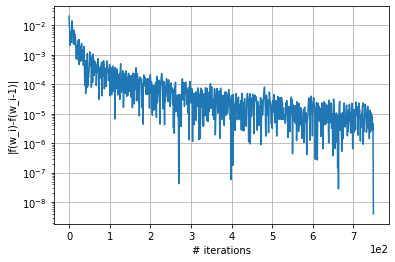

In [39]:
plt.plot(loss_sad)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()

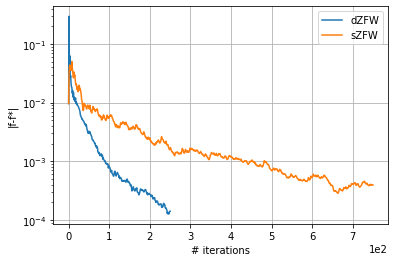

In [40]:
plt.plot(f_valuesd - f_star)
plt.plot(f_valuess - f_star)
plt.legend(('dZFW', 'sZFW'))
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.yscale("log")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

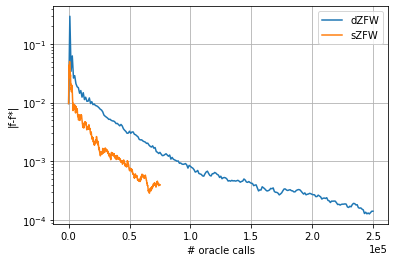

In [41]:
plt.plot(range(1, 251*d, d), f_valuesd - f_star)
plt.plot(range(0, 750*100+1, 100), f_valuess - f_star)
plt.yscale("log")
plt.xlabel("# oracle calls")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW'))
plt.grid()


## Zeroth order stochastic accelerated gradient method with Inexact updates

In [42]:
%%time 

# setting parameters
B=1   
L = 0.1
D = 2000 # we will start from m = 1, up to T * (T+1) / D * (d+3) = 1038 (for T = 45)
B = 1

fpred, f, w, mean, t, loss, f_values, inner = IZFW(F, d, w0, L, B, r = 1, T = 5, eps = 1e-8)

Loss evaluation at time 1:	0.0304269

Loss evaluation at time 2:	0.0060638

Loss evaluation at time 3:	0.0091177

Loss evaluation at time 4:	0.0007552

Loss evaluation at time 5:	0.0070646

CPU times: user 7.37 s, sys: 1.16 s, total: 8.52 s
Wall time: 2.59 s


In [43]:
loss_i = np.load("../Data/results/loss_IZFW_lasso_AD.npy", loss)
f_i = np.load("../Data/results/function_IZFW_lasso_AD.npy", f_values)
inner = np.load()

FileNotFoundError: [Errno 2] No such file or directory: '../Data/results/loss_IZFW_lasso_AD.npy'

In [ ]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

In [ ]:
plt.plot(f_values)

In [ ]:
m = lambda t: t * (t+1) / D * (d+3)
plt.plot(range(1, 251*d, d), f_valuesd - F(w_star))
plt.plot(range(0, 750*100+1, 100), f_valuess - F(w_star))
plt.plot([m(t) for t in range(101)], f - F(w_star))
plt.yscale("log")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW'))
plt.grid()

